<a href="https://colab.research.google.com/github/rzeller/sandbox/blob/main/notebooks/develop_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
cd /content/drive/MyDrive/code/sandbox

/content/drive/MyDrive/code/sandbox


In [20]:
!git pull origin HEAD

remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 7 (delta 2), reused 4 (delta 1), pack-reused 0
Unpacking objects: 100% (7/7), done.
From https://github.com/rzeller/sandbox
 * branch            HEAD       -> FETCH_HEAD
Updating eb6e2aa..caa7a25
Fast-forward
 notebooks/develop_models.ipynb | 625 +++++++++++++++++++++++++++++++++++++++++
 1 file changed, 625 insertions(+)
 create mode 100644 notebooks/develop_models.ipynb


# Generating the synthetic data

We start by generating the synthetic data.

In [1]:
from importlib import reload
import sys
sys.path.append("..")

import create_data
reload(create_data)

<module 'create_data' from '/Users/rzeller/Documents/code/sandbox/notebooks/../create_data.py'>

In [2]:
df = create_data.create_synthetic_data()

In [3]:
df.head()

,mnist_label,image,weight,pickup_x,pickup_y,dropoff_x,dropoff_y,distance,shipping_fee,train_test
0,5,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",5.152541,825.204338,501.569189,2399.712068,961.215342,1640.228392,8.451344,train
1,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",-0.148826,2684.808476,46.507780,1927.093473,762.862387,1042.734842,5.000000,train
2,4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4.091642,1103.542517,503.823956,2263.196730,161.049650,1209.252710,5.000000,train
3,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1.212798,2.429143,644.672512,834.275842,820.539213,850.234102,5.000000,train
4,9,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",9.268218,1309.729941,244.172206,2672.771419,754.563365,1455.465976,13.489576,train


# Create the CNN

We create a convolutional neural net and show that it can predict the mnist labels with >98% accuracy on the test data.


In [13]:
#models
import tensorflow
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape

# 784 - [32C5-P2] - [64C5-P2] - 128 -10
def create_cnn(regress=False, summarize=False):
  model = Sequential()
  model.add(Conv2D(filters=32, kernel_size=5, activation='relu', input_shape=(28, 28, 1)))
  model.add(MaxPool2D())
  model.add(Conv2D(filters=64, kernel_size=5, activation='relu'))
  model.add(MaxPool2D())
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))

  if regress:
    model.add(Dense(10, activation='softmax'))

  if summarize:
    print(model.summary())
  
  return model


In [15]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = np.stack(df[df['train_test']=='train']['image'])
y_train = to_categorical(np.stack(df[df['train_test']=='train']['mnist_label']))
x_test = np.stack(df[df['train_test']=='test']['image'])
y_test = to_categorical(np.stack(df[df['train_test']=='test']['mnist_label']))

model = create_cnn(regress=True, summarize=True)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

epochs = 10
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs,
          batch_size=32, verbose=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 64)          51264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 4, 4, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 128)              

(0.975, 1.0)

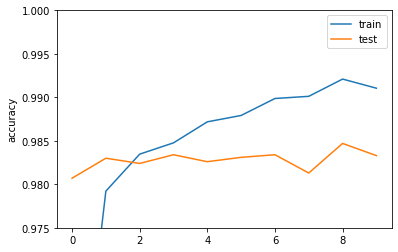

In [17]:
from matplotlib import pylab as plt
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend(loc='best')
plt.ylabel('accuracy')
plt.ylim([0.975, 1])

# Create the MLP

We need to create an MLP to handle the features other than the MNIST images in our data set as well as an MLP to combine the two types of data. 

In [ ]:
# make sure we can predict the shipping fees if we know the weights
import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer

train, test = (df['train_test']==i for i in ['train', 'test'])





def preprocess_features(continuous, categorical):
    cs = MinMaxScaler().fit(df[train][continuous])
    train_continuous = cs.transform(df[train][continuous])
    test_continuous = cs.transform(df[test][continuous])

    binarizers = dict((feature, LabelBinarizer().fit(df[train][feature])) for feature in categorical)
    train_categorical = np.hstack([binarizers[feature].transform(df[train][feature]) for feature in categorical])
    test_categorical = np.hstack([binarizers[feature].transform(df[test][feature]) for feature in categorical])

    x_train = np.hstack([train_continuous, train_categorical])
    y_train = df[train]['shipping_fee'].values

    x_test = np.hstack([test_continuous, test_categorical])
    y_test = df[test]['shipping_fee'].values
    return x_train, y_train, x_test, y_test
    

def create_mlp(num_features, layer_sizes=[32,16], regress=False, summarize=False):
    model = Sequential()
    model.add(Dense(layer_sizes[0], input_shape=(num_features,), activation='relu'))
    for layer_size in layer_sizes[1:]:
        model.add(Dense(layer_size, activation='relu'))

    if regress:
        model.add(Dense(1, activation='linear'))

    if summarize:
        print(model.summary())    
    return model
    
    
continuous = ['pickup_x', 'pickup_y', 'dropoff_x', 'dropoff_y', 'weight']
categorical = ['mnist_label']
layer_sizes = [32,32,32]
    
x_train, y_train, x_test, y_test = preprocess_features(continuous=continuous, categorical=categorical)
mlp = create_mlp(num_features=x_train.shape[1], layer_sizes=layer_sizes, regress=True, summarize=True)

mlp.compile(optimizer="adam", loss="mse", metrics=["mse"])

epochs = 15
history = mlp.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs,
          batch_size=32, verbose=True)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 32)                512       
                                                                 
 dense_43 (Dense)            (None, 32)                1056      
                                                                 
 dense_44 (Dense)            (None, 32)                1056      
                                                                 
 dense_45 (Dense)            (None, 1)                 33        
                                                                 
Total params: 2,657
Trainable params: 2,657
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/15
1875/1875 [==============================] - 2s 838us/step - loss: 4.0001 - mse: 4.0001 - val_loss: 0.2310 - val_mse: 0.2310
Epoch 2/15
1875/1875 [====================

(0.0, 0.1)

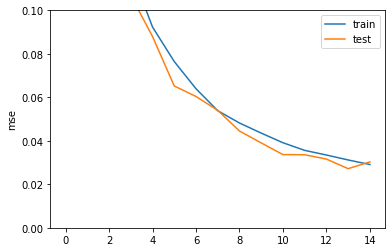

In [68]:
from matplotlib import pylab as plt
plt.plot(history.history['mse'], label='train')
plt.plot(history.history['val_mse'], label='test')
plt.legend(loc='best')
plt.ylabel('mse')
plt.ylim([0, .1])

In [64]:
df.columns

Index(['mnist_label', 'image', 'weight', 'pickup_x', 'pickup_y', 'dropoff_x',
       'dropoff_y', 'distance', 'shipping_fee', 'train_test'],
      dtype='object')